In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pysindy as ps

## Numerical solutions

In [5]:
omega = 1.00

def SHO (t, y):
    x, v = y
    dxdt = v 
    dvdt = -omega**2 * x 
    return [dxdt, dvdt]

y0 = [1.0 , 1.0]
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

solution_sho = solve_ivp (SHO, t_span, y0, t_eval=t_eval)

In [7]:
# solve diffusion pde

numx = 101
numt = 2001
Lx = 1.0
Tf = 0.1
dx = Lx / (numx-1)
dt = Tf / (numt-1)

x = np.arange(0, Lx + dx, dx)
t = np.arange(0, Tf + dt, dt)

phi = np.zeros((numx, numt))

mu = 0.5
sigma = 0.05
phi[:, 0] = np.exp( -(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

In [8]:
for j in np.arange(0, numt-1): 
    for i in np.arange(1, numx-1): 
        phi[i, j+1] = phi[i, j] + (dt/dx**2) * (phi[i+1, j] - 2*phi[i, j] + phi[i-1, j])
    phi[0, j+1] = phi[1, j+1]    
    phi[numx-1, j+1] = phi[numx-2, j+1]

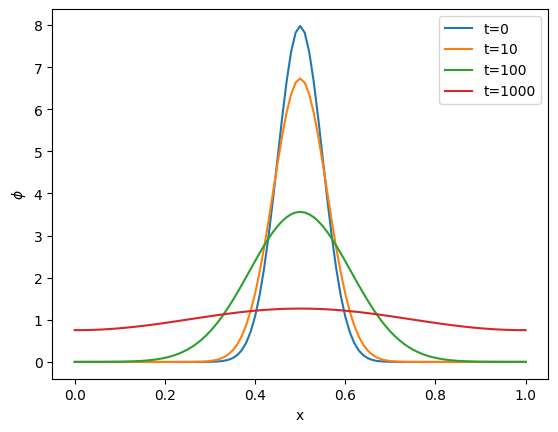

In [9]:
plt.plot(x , phi[:,0], label='t=0')
plt.plot(x, phi[:, 10], label='t=10')
plt.plot(x, phi[:, 100], label='t=100')
plt.plot(x, phi[:, 1000], label='t=1000')
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.legend()
plt.show()

In [10]:
print(f'$\phi$ shape={phi.shape}')
print(f'x shape={x.shape}')
print(f't shape={t.shape}')

$\phi$ shape=(101, 2001)
x shape=(101,)
t shape=(2001,)


In [11]:
phi_dot = ps.FiniteDifference(axis=1)._differentiate(phi, t=dt)

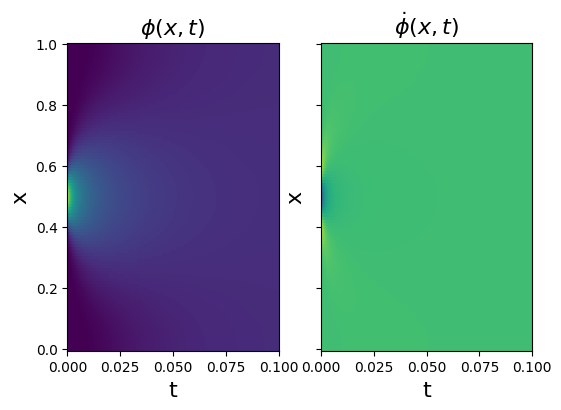

In [12]:
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot phi and phi_dot
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, phi)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\phi(x, t)$', fontsize=16)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, phi_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{\phi}(x, t)$', fontsize=16)
plt.show()

In [13]:
phi_ps = phi[:,:,np.newaxis]
print(phi_ps.shape)

(101, 2001, 1)


## Clean diffusion + SINDy

In [64]:

pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=1e-5, )#normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    #normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, max_iter=10000, tol=1e-15, 
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SSR model: ')
optimizer = ps.SSR(kappa=1) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   #normalize_columns=True, 
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('FROLs model: ')
optimizer = ps.FROLS(kappa=1e-3) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

STLSQ model: 
du/dt = 1.016 u_11
SR3 model, L0 norm: 
du/dt = 0.000
SR3 model, L1 norm: 
du/dt = -1.155 u + 1.010 u^2 + 1.001 u_11 + 0.013 uu_11 + -0.001 u^2u_11
SSR model: 
du/dt = 0.172 u^2 + 1.019 u_11
SSR (metric = model residual) model: 
du/dt = 1.006 u_11 + 0.002 uu_11
FROLs model: 
du/dt = 0.000


## Noisy diffusion + normal SINDy

In [65]:
eta_list = np.array([0., 0.01, 0.02, 0.05, 0.1])

phi_noisy = np.array([phi_ps + eta * np.random.random(phi_ps.shape) for eta in eta_list])

phi_noisy_dot = np.array([ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt) for i in range(phi_noisy.shape[0])])

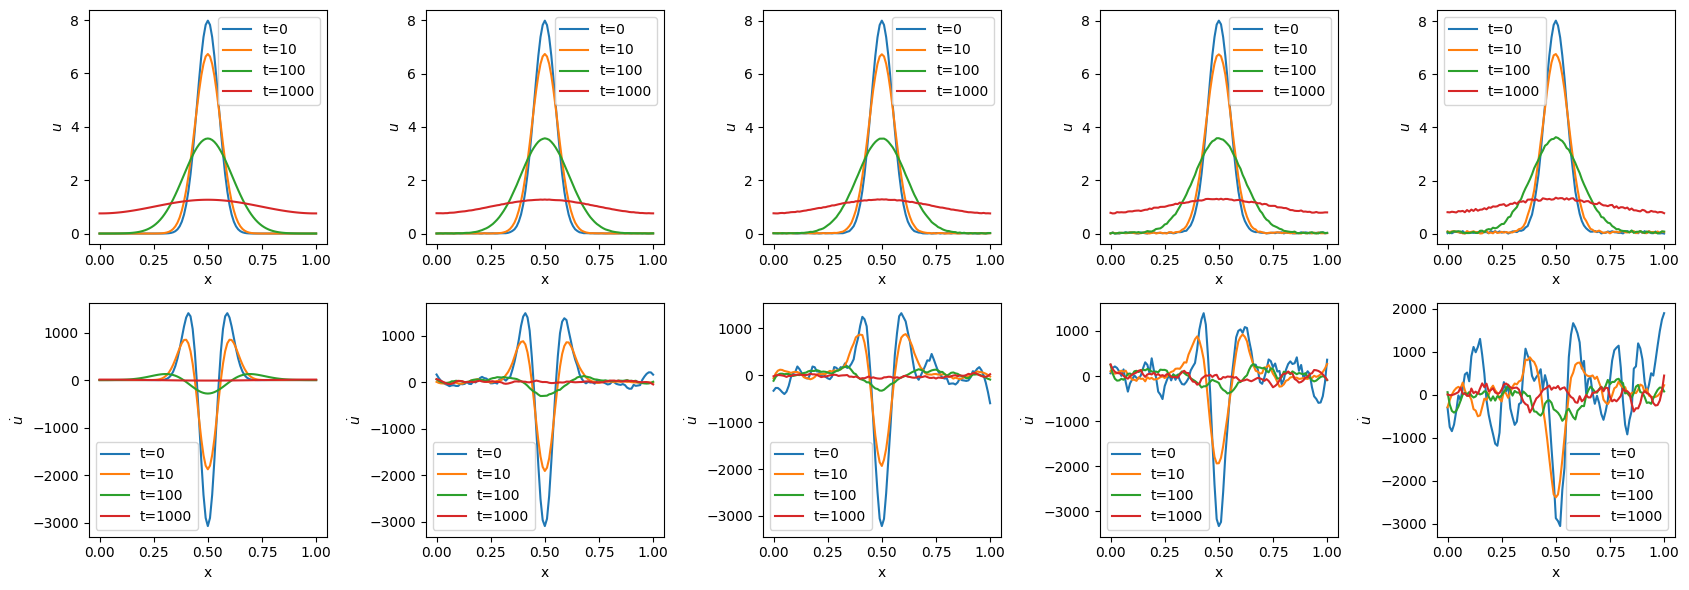

In [73]:
fig, axs = plt.subplots(2,len(eta_list), figsize = (17,6))
for i in range(len(eta_list)): 
    axs[0, i].plot(x , phi_noisy[i, :,0], label='t=0')
    axs[0, i].plot(x, phi_noisy[i, :, 10], label='t=10')
    axs[0, i].plot(x, phi_noisy[i, :, 100], label='t=100')
    axs[0, i].plot(x, phi_noisy[i, :, 1000], label='t=1000')
    axs[0, i].set_xlabel('x')
    axs[0, i].set_ylabel('$u$')
    axs[0, i].legend()
    
for i in range(len(eta_list)): 
    axs[1, i].plot(x , phi_noisy_dot[i, :,0], label='t=0')
    axs[1, i].plot(x, phi_noisy_dot[i, :, 10], label='t=10')
    axs[1, i].plot(x, phi_noisy_dot[i, :, 100], label='t=100')
    axs[1, i].plot(x, phi_noisy_dot[i, :, 1000], label='t=1000')
    axs[1, i].set_xlabel('x')
    axs[1, i].set_ylabel('$\dot{u}$')
    axs[1, i].legend()

fig.tight_layout()
fig.show()

In [78]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)


print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=1e-3, )#normalize_columns=True)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t']
                     #differentiation_method=ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-5)
                     )
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print(lhs = ['du/dt'])
    


print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=1,
    max_iter=1000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    #normalize_columns=True,
)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print(lhs = ['du/dt'])
    


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=1, max_iter=1000, tol=1e-15, 
    thresholder="l1", normalize_columns=True
)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print(lhs = ['du/dt'])
 
 
    
print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   #normalize_columns=True, 
                   kappa=1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs = ['du/dt'])
    
    
print('FROLs model: ')
optimizer = ps.FROLS(kappa=1e-5, normalize_columns=True)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs = ['du/dt'])

STLSQ model: 
du/dt = 1.016 u_11
du/dt = 51.690 u + -39.867 u^2
du/dt = 51.916 u + -39.909 u^2
du/dt = 52.072 u + -39.616 u^2
du/dt = 52.091 u + -38.950 u^2
SR3 model, L0 norm: 
du/dt = -1.186 u + 1.035 u^2 + 1.000 u_11
du/dt = 15.998 u + -12.054 u^2
du/dt = 25.926 u + -20.167 u^2
du/dt = 34.079 u + -26.516 u^2
du/dt = 39.734 u + -30.156 u^2
SR3 model, L1 norm: 
du/dt = -1.124 u + 0.985 u^2 + 1.001 u_11 + 0.012 uu_11 + -0.001 u^2u_11
du/dt = 15.991 u + -12.055 u^2 + 0.062 u_11 + 0.021 uu_1 + -0.005 u^2u_1 + 0.193 uu_11 + -0.012 u^2u_11
du/dt = 25.911 u + -20.160 u^2 + -0.025 u_1 + -0.013 u_11 + -0.003 uu_1 + 0.004 u^2u_1 + 0.088 uu_11 + 0.001 u^2u_11
du/dt = 34.063 u + -26.507 u^2 + -0.021 u_1 + 0.011 u_11 + 0.119 uu_1 + -0.016 u^2u_1 + -0.014 uu_11 + 0.012 u^2u_11
du/dt = 39.724 u + -30.151 u^2 + -0.121 u_1 + 0.012 u_11 + -0.141 uu_1 + 0.053 u^2u_1 + -0.023 uu_11 + 0.010 u^2u_11
SSR (metric = model residual) model: 
du/dt = -1.186 u + 1.035 u^2 + 1.000 u_11 + 0.013 uu_11 + -0.001 u^2u

## Noisy diffusion + Weak formulation

In [82]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=3,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
)

In [85]:

print('Weak form, STLSQ model: ')
optimizer = ps.STLSQ(threshold=.1, 
                     alpha=1e-3, )

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])



print('Weak form, SR3: ')

optimizer = ps.SR3(threshold=0.1, 
                   thresholder="l0", 
                   tol=1e-8, 
                   normalize_columns=True, 
                   max_iter=1000)
np.random.seed(1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                     differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])
    
    

print('Weak form, SR3, L0: ')

optimizer = ps.SR3(threshold=.5, 
                   thresholder="l0", 
                   tol=1e-8, 
                   normalize_columns=False, 
                   max_iter=1000)
np.random.seed(1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])
    
    
print('Weak form, SR3 model, L1 norm: ')    

optimizer = ps.SR3(
    threshold=0.01, max_iter=1000, tol=1e-8, 
    thresholder="l1", normalize_columns=True
)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])
    

print('Weak form, FROLS model: ')
optimizer = ps.FROLS(kappa=1e-4, normalize_columns=True, verbose=False)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])    



Weak form, STLSQ model: 
du/dt = 1.002 u_11
du/dt = 1.002 u_11
du/dt = 1.001 u_11
du/dt = 0.994 u_11
du/dt = 0.899 u_11 + 0.034 uu_11
Weak form, SR3: 
du/dt = 1.001 u_11
du/dt = 1.005 u_11
du/dt = 1.004 u_11
du/dt = 0.994 u_11
du/dt = 0.954 u_11
Weak form, SR3, L0: 
du/dt = 1.000 u_11
du/dt = -0.845 1 + 0.524 u + 1.015 u_11
du/dt = -3.498 1 + 3.263 u + 1.030 u_11
du/dt = -13.756 1 + 21.075 u + -9.201 u^2 + 1.399 u^3 + 1.018 u_11
du/dt = -12.341 1 + 20.179 u + -8.676 u^2 + 1.180 u^3 + 0.973 u_11
Weak form, SR3 model, L1 norm: 
du/dt = 0.678 u_11
du/dt = 0.708 u_11
du/dt = 0.711 u_11
du/dt = 0.702 u_11
du/dt = 0.670 u_11
Weak form, FROLS model: 
du/dt = 1.002 u_11
du/dt = 1.002 u_11
du/dt = 1.001 u_11
du/dt = 0.994 u_11
du/dt = 0.967 u_11


In [58]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
)

optimizer = ps.STLSQ(threshold=.1, alpha=1e-3, )

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(),
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print()

Weak form, FROLS model: 
(x0)' = 1.002 x0_11
(x0)' = 1.001 x0_11
(x0)' = 0.994 x0_11
(x0)' = 0.899 x0_11 + 0.032 x0x0_11
(x0)' = 0.886 x0_11


## Growth + diffusion

In [102]:
# solve diffusion pde

numx = 101
numt = 2001
Lx = 1.0
Tf = 0.1
dx = Lx / (numx-1)
dt = Tf / (numt-1)

x = np.arange(0, Lx + dx, dx)
t = np.arange(0, Tf + dt, dt)

pop = np.zeros((numx, numt))
r = np.zeros((numx, numt))

mu = 0.5
sigma = 0.05
alpha = 0.7
v = 1.
pop[:, 0] = np.exp( -(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

for j in range(t.shape[0]):
    r[:, j] = 0.01 * np.exp( -(x - alpha + j*v*dt)**2)



In [92]:
t.size

2001

In [103]:
for j in np.arange(0, numt-1): 
    for i in np.arange(1, numx-1): 
        pop[i, j+1] = pop[i, j]*(1 + r[i,j]) + (dt/dx**2) * (pop[i+1, j] - 2*pop[i, j] + pop[i-1, j])
    pop[0, j+1] = pop[1, j+1]    
    pop[numx-1, j+1] = pop[numx-2, j+1]

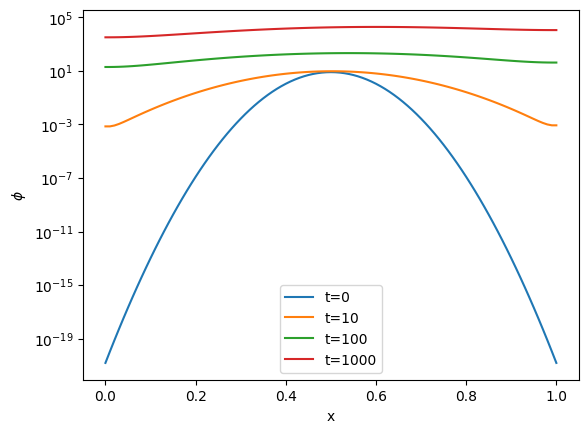

In [105]:
plt.plot(x , pop[:,0], label='t=0')
plt.plot(x, pop[:, 100], label='t=10')
plt.plot(x, pop[:, 500], label='t=100')
plt.plot(x, pop[:, 1000], label='t=1000')
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.yscale('log')
plt.legend()
plt.show()

In [106]:
pop_ps = pop[:,:,np.newaxis]
print(pop_ps.shape)

(101, 2001, 1)


In [107]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, 
                     alpha=1e-5, 
                     normalize_columns=True
                      )
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n'])
model.fit(pop_ps, t=dt, u=r)
model.print(lhs=['dn/dt'])



STLSQ model: 


IndexError: list index out of range

In [ ]:
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n'])
model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, 
    max_iter=1000, 
    tol=1e-15, 
    thresholder="l1", 
    normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n'])
model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])

print('SSR model: ')
optimizer = ps.SSR(kappa=1) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n'])
model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   normalize_columns=True, 
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n'])
model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])

print('FROLs model: ')
optimizer = ps.FROLS(kappa=1e-3) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n'])
model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])